Apply Autoencoder on the Cifar_10 dataset and then pass the result of Autoencoder to CNN or LSTM or three layers model to classify data

a.	Repeat the same thing with PCA (apply PCA on the dataset and then pass the result to CNN or LSTM or three layers model)

b.	Compare the result of both approach


**AutoEncoder+CNN**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from time import time
from random import randint

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import load_model

from keras import regularizers
from keras import backend as K

from keras.datasets import cifar10
from keras.utils import np_utils
from keras.constraints import maxnorm
from keras.layers import Dense, Input
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.models import Model
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() # loading data into dataframe

In [3]:
x_train = x_train.reshape(50000,3,32,32).transpose(0,2,3,1).astype("uint8") #uint8-data type contains all whole numbers from 0 to 255
x_test = x_test.reshape(10000,3,32,32).transpose(0,2,3,1).astype("uint8") #uint8-data type contains all whole numbers from 0 to 255

In [4]:
x_train = x_train.astype('uint8') / 255. # Scaling inputs from 0-255 to 0.0-1.0
x_test = x_test.astype('uint8') / 255. # Scaling inputs from 0-255 to 0.0-1.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))) #flatten 32x32 images into vectors of size 3072
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:]))) #flatten 32x32 images into vectors of size 3072
print(x_train.shape)
print(x_test.shape)

(50000, 3072)
(10000, 3072)


In [5]:
# one hot encoding on target labels
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]
num_classes

10

In [6]:
j = randint(0,10000)

# Single fully-connected neural layer as encoder and decoder

encoding_dim = 128  # 128 floats -> compression of 24 for each Neuron, as the input shape is 3072
input_img = Input(shape=(3072,)) #Input shape is 3072 from X_train.shape, X_test.shape
encoded = Dense(encoding_dim, activation='relu')(input_img) # 128 Neurons for encoded representations
decoded = Dense(3072, activation='sigmoid')(encoded) #Output & Input Neurons should be same as Mirror image
autoencoder = Model(input_img, decoded) #maps an input to its reconstruction
encoder = Model(input_img, encoded) #maps an input to its encoded representation

# Decoder Model
encoded_input = Input(shape=(encoding_dim,)) # create a placeholder for an encoded (32-dimensional) input
decoder_layer = autoencoder.layers[-1] # retrieve the last layer of the autoencoder model
decoder = Model(encoded_input, decoder_layer(encoded_input)) # create the decoder model

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy']) # Autoencoder model configuration

In [7]:
tensorboard = TensorBoard(log_dir='2', histogram_freq=0, write_graph=True, write_images=False)
history = autoencoder.fit(x_train, x_train, epochs=3, batch_size=256, shuffle=True, validation_data=(x_test, x_test), callbacks=[tensorboard])

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 14s 270us/step - loss: 0.6927 - accuracy: 0.0066 - val_loss: 0.6915 - val_accuracy: 0.0072
Epoch 2/3
50000/50000 [==============================] - 14s 282us/step - loss: 0.6875 - accuracy: 0.0082 - val_loss: 0.6819 - val_accuracy: 0.0091
Epoch 3/3
50000/50000 [==============================] - 14s 270us/step - loss: 0.6768 - accuracy: 0.0094 - val_loss: 0.6718 - val_accuracy: 0.0097


In [8]:
# reconstructed inputs and encoded representations

# encode and decode on test data
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

**Autoencoder output for CNN**

In [9]:
x_train2 = x_train

for i in range(0, 50000):
  prediction = autoencoder.predict(x_train[i].reshape(1,3072))
  x_train2[i] = prediction

In [10]:
x_test2 = x_test.copy()

for i in range(0, 10000):
  prediction = autoencoder.predict(x_test[i].reshape(1,3072))
  x_test2[i] = prediction

In [11]:
# Change input shape from (,3072) to (,32,32,3)

x_train2 = np.array(x_train2).reshape([-1, 32, 32, 3]) 
x_train2.shape

x_test2 = np.array(x_test2).reshape([-1, 32, 32, 3]) 
x_test2.shape

(10000, 32, 32, 3)

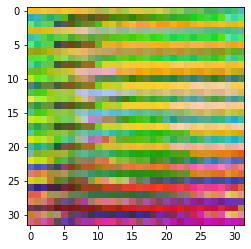

In [12]:
# result of autoencoder on a random image from test dataset

# original Image
plt.imshow(x_test[j].reshape(32,32,3))
plt.show()

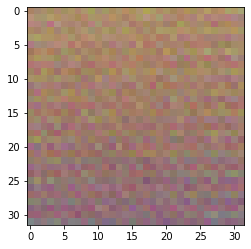

In [13]:
# reconstruction Image
plt.imshow(x_test2[j].reshape(32,32,3))
plt.show()

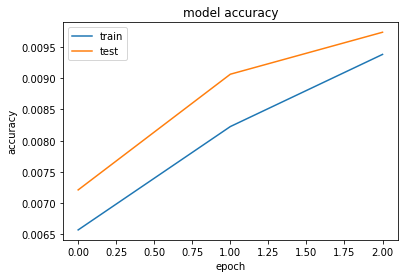

In [14]:
#history graph for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

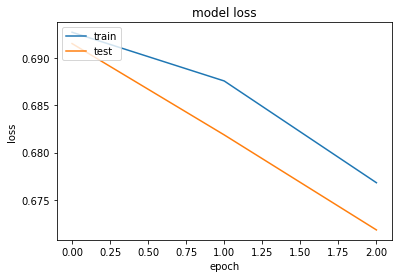

In [15]:
# history graph for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Applying CNN on AutoEncoded Data**

In [16]:
model = models.Sequential() #Sequential Neural Network
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32,32,3), kernel_constraint=maxnorm(3))) #2D convolutinal model
model.add(layers.Dropout(0.2)) #Dropout 20%
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2))) #Max pool of size (2*2)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(layers.Dropout(0.5)) #drop out of 50%
model.add(layers.Dense(num_classes, activation='softmax')) #10 Output Neurons
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

In [17]:
epochs = 5
lrate = 0.01
decay = lrate/epochs
sgd = keras.optimizers.SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy']) # Compiling model

In [18]:
historynew = model.fit(x_train2, y_train, validation_data=(x_test2, y_test), epochs=epochs, batch_size=32) # Fitting the model

Epoch 1/5
1563/1563 [==============================] - 230s 147ms/step - loss: 2.2102 - accuracy: 0.1629 - val_loss: 2.1869 - val_accuracy: 0.1797
Epoch 2/5
1563/1563 [==============================] - 237s 151ms/step - loss: 2.1742 - accuracy: 0.1853 - val_loss: 2.1617 - val_accuracy: 0.1991
Epoch 3/5
1563/1563 [==============================] - 232s 148ms/step - loss: 2.1565 - accuracy: 0.1976 - val_loss: 2.1424 - val_accuracy: 0.2198
Epoch 4/5
1563/1563 [==============================] - 231s 148ms/step - loss: 2.1413 - accuracy: 0.2067 - val_loss: 2.1327 - val_accuracy: 0.2224
Epoch 5/5
1563/1563 [==============================] - 232s 149ms/step - loss: 2.1261 - accuracy: 0.2162 - val_loss: 2.1099 - val_accuracy: 0.2298


In [19]:
# Accuracy score
scores = model.evaluate(x_test2, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 22.98%


**a.	Repeat the same thing with PCA (apply PCA on the dataset and then pass the result to CNN or LSTM or three layers model)**

**PCA+CNN**

In [20]:
x_train = x_train.reshape(-1, 3072)
x_test = x_test.reshape(-1, 3072)
print(x_train.shape)
print(x_test.shape)

(50000, 3072)
(10000, 3072)


In [21]:
# Apply standard scaler to data
standardscaler = StandardScaler()

In [22]:
#PCA

pca = PCA()
pca.fit(x_train)
pca.n_components_
pca.explained_variance_
pca.explained_variance_.shape

(3072,)

In [23]:
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

In [24]:
x_train_pca = x_train_pca.reshape(-1, 32,32,3)
x_test_pca = x_test_pca.reshape(-1, 32,32,3)
print(x_train_pca.shape)
print(x_test_pca.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [25]:
model1 = models.Sequential() #Sequential Neural Network
model1.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32,32,3), kernel_constraint=maxnorm(3))) #2D convolutinal model
model1.add(layers.Dropout(0.2)) #Dropout 20%
model1.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(layers.Flatten())
model1.add(layers.Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model1.add(layers.Dropout(0.5)) #Dropout 50%
model1.add(layers.Dense(num_classes, activation='softmax'))  #10 Output Neurons
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [26]:
epochs = 3
lrate = 0.01
decay = lrate/epochs
sgd = keras.optimizers.SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model1.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy']) #Compiling Model

In [27]:
history1 = model1.fit(x_train_pca, y_train, validation_data=(x_test_pca, y_test), epochs=epochs, batch_size=32) #Fitting The model

Epoch 1/3
1563/1563 [==============================] - 231s 148ms/step - loss: 2.1719 - accuracy: 0.1856 - val_loss: 2.1581 - val_accuracy: 0.1990
Epoch 2/3
1563/1563 [==============================] - 231s 148ms/step - loss: 2.1056 - accuracy: 0.2200 - val_loss: 2.2075 - val_accuracy: 0.2225
Epoch 3/3
1563/1563 [==============================] - 232s 149ms/step - loss: 2.0647 - accuracy: 0.2398 - val_loss: 2.2763 - val_accuracy: 0.2252


In [28]:
# Accuracy score
scores = model1.evaluate(x_test_pca, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 22.52%


**b.	Compare the result of both approach**

In [29]:
scores = model.evaluate(x_test2, y_test, verbose=0)
print("Accuracy for AutoEncoding + CNN: %.2f%%" % (scores[1]*100))

scores = model1.evaluate(x_test_pca, y_test, verbose=0)
print("Accuracy for PCA + CNN: %.2f%%" % (scores[1]*100))

Accuracy for AutoEncoding + CNN: 22.98%
Accuracy for PCA + CNN: 22.52%
